Install all required packages.

In [ ]:
!pip install scanpy==1.4.6 umap-learn==0.4.0 anndata==0.7.1 numpy==1.18.2 scipy==1.4.1 pandas matplotlib scrublet seaborn python-igraph==0.8.0 louvain==0.6.1 !pip install scanpy==1.4.6 umap-learn==0.4.0 anndata==0.7.1 numpy==1.18.2 scipy==1.4.1 pandas matplotlib scrublet seaborn python-igraph==0.8.0 louvain==0.6.1 gprofiler

In [1]:
import scanpy as sc
import anndata as ann
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors

import os 
#doublet detection
import scrublet as scr
#batch correction (not installed by default in the docker container, install via command line: pip install scanorama bbknn)
import scanorama as scan
#external modules
import scanpy.external as sce
#pretty plotting
import seaborn as sb
#gene set enrichment analysis
from gprofiler import GProfiler

import logging




/opt/python/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()


scanpy==1.4.6 anndata==0.7.1 umap==0.4.0 numpy==1.18.2 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


Of note, this notebook was created as part of a workshop, so we use extra large legend texts in all seaborn plots. You can set the context as well to 'talk' or 'paper'.

In [3]:
sb.set_context(context='poster')


Create a plotting function that works with the gprofiler output.

In [87]:
# Plotting functions - 'GProfiler-official version'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib import colors
from matplotlib import rcParams


def scale_data_5_75(data):
    mind = np.min(data)
    maxd = np.max(data)
    
    if maxd == mind:
        maxd=maxd+1
        mind=mind-1
        
    drange = maxd - mind
    return ((((data - mind)/drange*0.70)+0.05)*100)


def plot_enrich(data, n_terms=20, save=False):
    # Test data input
    if not isinstance(data, pd.DataFrame):
        raise ValueError('Please input a Pandas Dataframe output by gprofiler.')
        
    if not np.all([term in data.columns for term in ['p_value', 'name', 'intersection_size']]):
        raise TypeError('The data frame {} does not contain enrichment results from gprofiler.'.format(data))
    
    data_to_plot = data.iloc[:n_terms,:].copy()
    data_to_plot['go.id'] = data_to_plot.index

    min_pval = data_to_plot['p_value'].min()
    max_pval = data_to_plot['p_value'].max()
    
    # Scale intersection_size to be between 5 and 75 for plotting
    #Note: this is done as calibration was done for values between 5 and 75
    data_to_plot['scaled.overlap'] = scale_data_5_75(data_to_plot['intersection_size'])
    
    norm = colors.LogNorm(min_pval, max_pval)
    sm = plt.cm.ScalarMappable(cmap="cool", norm=norm)
    sm.set_array([])

    rcParams.update({'font.size': 14, 'font.weight': 'bold'})

    sb.set(style="whitegrid")

    path = plt.scatter(x='recall', y="name", c='p_value', cmap='cool', 
                       norm=colors.LogNorm(min_pval, max_pval), 
                       data=data_to_plot, linewidth=1, edgecolor="grey", 
                       s=[(i+10)**1.5 for i in data_to_plot['scaled.overlap']])
    ax = plt.gca()
    ax.invert_yaxis()

    ax.set_ylabel('')
    ax.set_xlabel('Gene ratio', fontsize=14, fontweight='bold')
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Get tick marks for this plot
    #Note: 6 ticks maximum
    min_tick = np.floor(np.log10(min_pval)).astype(int)
    max_tick = np.ceil(np.log10(max_pval)).astype(int)
    tick_step = np.ceil((max_tick - min_tick)/6).astype(int)
    
    # Ensure no 0 values
    if tick_step == 0:
        tick_step = 1
        min_tick = max_tick-1
    
    ticks_vals = [10**i for i in range(max_tick, min_tick-1, -tick_step)]
    ticks_labs = ['$10^{'+str(i)+'}$' for i in range(max_tick, min_tick-1, -tick_step)]

    #Colorbar
    fig = plt.gcf()
    cbaxes = fig.add_axes([0.8, 0.15, 0.03, 0.4])
    cbar = ax.figure.colorbar(sm, ticks=ticks_vals, shrink=0.5, anchor=(0,0.1), cax=cbaxes)
    cbar.ax.set_yticklabels(ticks_labs)
    cbar.set_label("Adjusted p-value", fontsize=14, fontweight='bold')

    #Size legend
    min_olap = data_to_plot['intersection_size'].min()
    max_olap = data_to_plot['intersection_size'].max()
    olap_range = max_olap - min_olap
    
    #Note: approximate scaled 5, 25, 50, 75 values are calculated
    #      and then rounded to nearest number divisible by 5
    size_leg_vals = [np.ceil(i/5)*5 for i in 
                          [min_olap, min_olap+(20/70)*olap_range, min_olap+(45/70)*olap_range, max_olap]]
    size_leg_scaled_vals = scale_data_5_75(size_leg_vals)

    
    l1 = plt.scatter([],[], s=(size_leg_scaled_vals[0]+10)**1.5, edgecolors='none', color='black')
    l2 = plt.scatter([],[], s=(size_leg_scaled_vals[1]+10)**1.5, edgecolors='none', color='black')
    l3 = plt.scatter([],[], s=(size_leg_scaled_vals[2]+10)**1.5, edgecolors='none', color='black')
    l4 = plt.scatter([],[], s=(size_leg_scaled_vals[3]+10)**1.5, edgecolors='none', color='black')

    labels = [str(int(i)) for i in size_leg_vals]

    leg = plt.legend([l1, l2, l3, l4], labels, ncol=1, frameon=False, fontsize=12,
                     handlelength=1, loc = 'center left', borderpad = 1, labelspacing = 1.4,
                     handletextpad=2, title='Gene overlap', scatterpoints = 1,  bbox_to_anchor=(-2, 1.5), 
                     facecolor='black')

    if save:
        plt.savefig(save, dpi=300, format='pdf', bbox_inches='tight')

    plt.show()

# Introduction

The dataset consists of 12 samples from 3mm2 blocks that were manually dissected from the substantia nigra and cortex of 5 control (4 males & 1 female) de-identified post-mortem human donors,  including 2 substantia nigra (SN) replicates and sequenced using the 10X chromium system (V2) (GEO accession ID: [GSE140231](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE140231)).

In this notebook, we analyse the differentially expressed genes from the previous differential expression notebook. We show a typical analysis approach to understand differential expression signals: functional enrichment. Specifically, we are looking for Gene Ontology Biological Process annotations that are enriched in the set of differentially expressed genes between cortical and substantia nigra astrocytes.

This analysis is performed with g:profiler, or specifically with Valentine Svensson's python API for the g:profiler webtool. It should be noted that g:profiler's python API is currently being redesigned and thus the old python API (used here) is no longer supported and updated. To use the newest GO data, please check with the g:profiler team.

## Set project file paths

Let us set up the connection with Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

We set up the file paths to the respective directories.

In [ ]:
file_path = '/content/drive/My Drive/' #this is the file path to your google drive (main directory)

In [ ]:
os.listdir(file_path) #shows all files in file_path

The data directory contains all processed data and `anndata` files. 

In [12]:
data_dir = file_path + 'day2/data/' 

The tables directory contains all tabular data output, e.g. in `.csv` or `.xls` file format. That applies to differential expression test results or overview tables such as the number of cells per cell type.

In [13]:
table_dir = file_path + 'day2/tables/'

The default figure path is a POSIX path calles 'figures'. If you don't change the default figure directory, scanpy creates a subdirectory where this notebook is located.  

In [14]:
sc.settings.figdir = file_path + 'day2/figures/'

**Comment:** When you repeat certain analyses, it might be helpful to set a `date` variable and add it to every figure and table (see `datetime` Python package).

# Read data

We read in the annotated dataset. As a reminder, the `anndata` object contains (amongst others):
1. The raw counts as 'counts' layer. 
2. Normalised gene expression values (log-scran normalised) as `X` matrix
3. Cell type annotation
4. Size factors 

In [8]:
adata= sc.read(data_dir + 'data_processed.h5ad')

In [9]:
adata

AnnData object with n_obs × n_vars = 16069 × 23988 
    obs: 'batch', 'donor', 'location', 'replicate', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'doublet_score', 'doublet', 'size_factors', 'S_score', 'G2M_score', 'phase', 'louvain_r1.5', 'louvain_r0.5', 'annotated', 'DAN_r'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'DAN_r_colors', 'annotated_colors', 'astro', 'batch_colors', 'diffmap_evals', 'donor_colors', 'draw_graph', 'location_colors', 'louvain', 'louvain_r0.5_colors', 'louvain_r1.5_colors', 'neighbors', 'pca', 'phase_colors', 'rank_genes_r0.5', 'rank_genes_r1.5', 'replicate_colors', 'umap'
    obsm: 'X_diffmap', 'X_draw_graph_fa', 'X_emb', 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'

For the gene set enrichment, we want to use a custom background, which are all expressed genes in our dataset. By default, g:profiler uses all genes of the reference.

In [49]:
bg_genes = adata.var_names.tolist()

## Prepare test data

Here, we load our test data from the differential expression test and sort them into groups where they are expressed highest.

**Tasks:**
1. Read in the `csv` table with `pd.read_csv` (tip: set `index_col=0` to use the rownames as index).
2. Split the gene names by group (use the log-fold change). 
3. Filter out all genes with an absolute log-fold change of less than 0.5 and a q-value higher than 0.05. 

In [18]:
de_astro = pd.read_csv(table_dir + 'test_MB_astrocytes.csv', index_col=0)

In [19]:
de_astro.head()

,gene,pval,qval,log2fc,mean,zero_mean,grad,coef_mle,coef_sd,ll
0,RP11-34P13.3,1.000000,1.000000,0.000000,0.000000,True,4.661331e-130,0.000000,6.103423e+63,-1.520688e-127
1,RP11-34P13.7,0.000000,0.000000,-297.776029,0.006508,False,1.906350e-10,-297.776029,2.222759e-162,-1.320247e+01
2,FO538757.2,0.047386,0.155946,0.446211,0.214751,False,6.683640e-10,0.446211,2.250368e-01,-2.588135e+02
3,AP006222.2,0.727419,1.000000,-0.138595,0.056399,False,4.578814e-11,-0.138595,3.976202e-01,-1.013451e+02
4,RP4-669L17.10,0.817416,1.000000,0.400402,0.006508,False,9.817744e-11,0.400402,1.734314e+00,-1.488392e+01


In [27]:
high_in_first = de_astro.loc[np.logical_and(de_astro['log2fc']>0.5,
                                            de_astro['qval']<0.05),
                                            'gene'].values
high_in_second = de_astro.loc[np.logical_and(de_astro['log2fc']<-0.5,
                                             de_astro['qval']<0.05),
                                              'gene'].values

In [29]:
print(len(high_in_first))
print(len(high_in_second))

3842
2033


We want to check which condition was the reference (i.e. "second" with negative log-fold change) and which one was the test (i.e. "first" with positive log-fold change). For this purpose, we distinguish astrocytes by location in a new `obs` variable.

In [44]:
adata.obs['annotated_location'] = adata.obs['annotated'].cat.add_categories(['Astrocyte_SN', 'Astrocyte_C'])
adata.obs['annotated_location'][np.logical_and(adata.obs['annotated']=='Astrocyte',
                                             adata.obs['location']=='SN'
                                            )] = 'Astrocyte_SN'
adata.obs['annotated_location'][np.logical_and(adata.obs['annotated']=='Astrocyte',
                                             adata.obs['location']=='C'
                                            )] = 'Astrocyte_C'
adata.obs['annotated_location'] = adata.obs['annotated_location'].cat.remove_unused_categories()

Let us select 2 genes from the `high_in_first` list: `HES4` and `E2F2`.

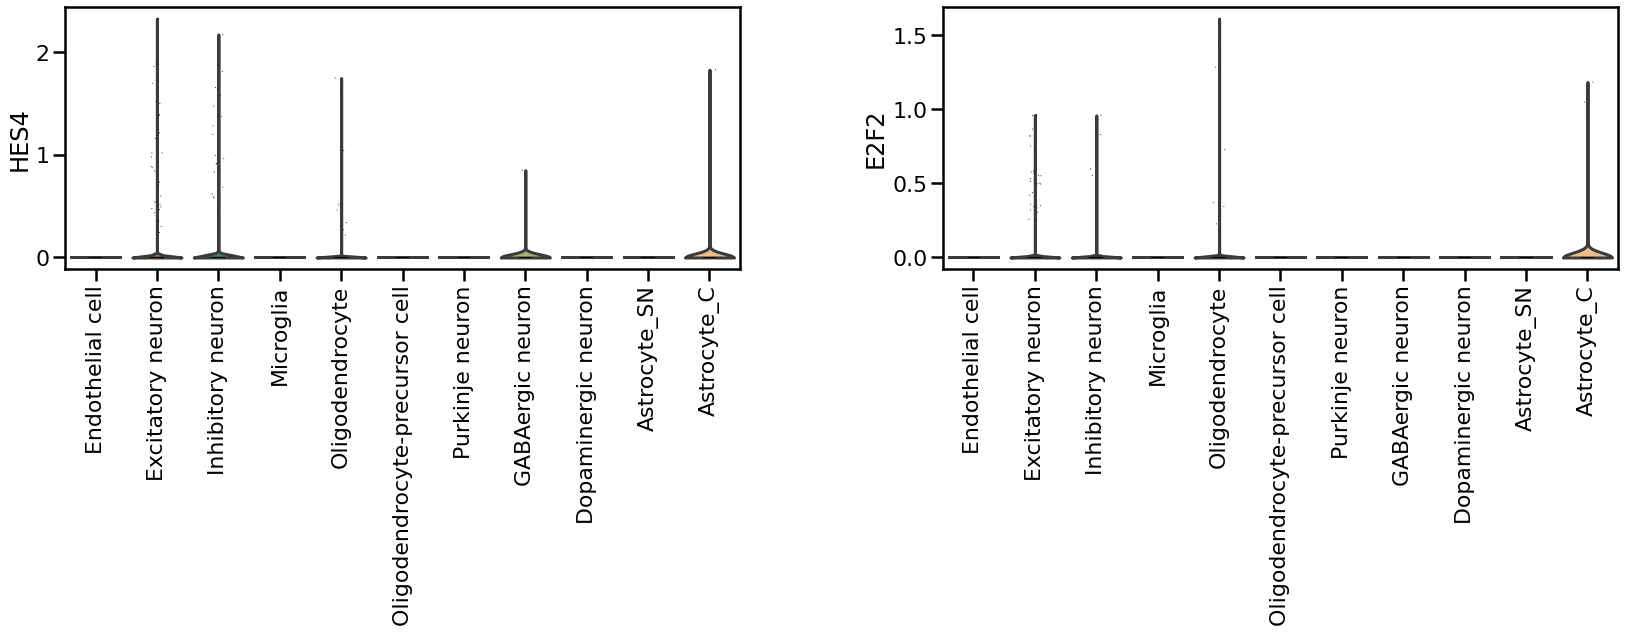

In [48]:
rcParams['figure.figsize']=(10,5)
sc.pl.violin(adata, groupby='annotated_location', keys=['HES4', 'E2F2'], rotation=90)

We observe that both genes are slightly higher in the cortical astrocytes, however, the expression level is quite low.

# Run g:profiler

In [4]:
#Interpretation of differentially expressed genes in paneth cells - g:profiler
gp = GProfiler(return_dataframe=True, user_agent='g:GOSt')

In [51]:
astroC_enrichment = gp.profile(organism='hsapiens', sources=['GO:BP'], user_threshold=0.05,
                               significance_threshold_method='fdr', 
                               background=bg_genes, 
                               query=high_in_first.tolist())

In [52]:
astroSN_enrichment = gp.profile(organism='hsapiens', sources=['GO:BP'], user_threshold=0.05,
                               significance_threshold_method='fdr', 
                               background=bg_genes, 
                               query=high_in_second.tolist())

Let us check the results.

In [53]:
astroC_enrich_results = astroC_enrichment.set_index('native').sort_values('p_value').iloc[:,[2,5,7,10,1]]

In [57]:
pd.set_option("display.max_colwidth", 800)
astroC_enrich_results.iloc[:30,:]

,p_value,term_size,intersection_size,recall,name
native,,,,,
GO:0007399,1.223964e-07,2161,421,0.194817,nervous system development
GO:0007267,1.223964e-07,1487,308,0.207128,cell-cell signaling
GO:0099536,2.072861e-06,684,159,0.232456,synaptic signaling
GO:0099537,5.379932e-06,668,154,0.230539,trans-synaptic signaling
GO:0048667,6.453874e-06,569,135,0.237258,cell morphogenesis involved in neuron differentiation
GO:0007186,8.626319e-06,746,166,0.222520,G protein-coupled receptor signaling pathway
GO:0007268,8.626319e-06,659,150,0.227618,chemical synaptic transmission
GO:0048699,8.626319e-06,1399,280,0.200143,generation of neurons
GO:0050804,8.626319e-06,430,107,0.248837,modulation of chemical synaptic transmission


Here we find differential expression of neuron-related GO terms enriched between cortical and substantia nigra astrocytes (e.g. "nervous system development", "generation of neurons", or "axonogenesis"). 

Let us check the results for the substantia nigra astrocytes.

In [71]:
astroSN_enrich_results = astroSN_enrichment.set_index('native').sort_values('p_value').iloc[:,[2,5,7,10,1]]

In [72]:
pd.set_option("display.max_colwidth", 800)
astroSN_enrich_results.iloc[:30,:]

,p_value,term_size,intersection_size,recall,name
native,,,,,
GO:0003341,1.102861e-14,68,32,0.470588,cilium movement
GO:0035082,1.455111e-09,56,24,0.428571,axoneme assembly
GO:0001578,3.713447e-09,85,29,0.341176,microtubule bundle formation
GO:0001539,5.101629e-08,95,29,0.305263,cilium or flagellum-dependent cell motility
GO:0060285,5.101629e-08,95,29,0.305263,cilium-dependent cell motility
GO:0044782,1.691796e-05,353,58,0.164306,cilium organization
GO:0006928,3.239352e-05,1827,199,0.108922,movement of cell or subcellular component
GO:0070286,4.942612e-05,29,13,0.448276,axonemal dynein complex assembly
GO:0007018,1.072917e-04,269,46,0.171004,microtubule-based movement


It is common to do this analysis with only up- or down-regulated genes depending on which biological hypotheses are investigated. By performing GO term enrichment on the up- and down-regulated genes together we find annotations of biological processes that are differentially expressed between proximal and distal paneth cells, but we cannot say whether one of the two regions particularly up-regulates the genes in a process or down-regulates them. This can only be addressed by separating genes based on log fold change.

It should be noted that relative over- or under-expression of genes does not have to map to up- or down-regulation of a biological process. For example, relatively lower expression levels of a pathway inhibitor, will result in an up-regulation of the activity of this pathway, while the opposite is true for low expression of a promoter. Thus, a more detailed investigation is generally necessary to conclude the direction of regulation of a process between conditions.


A more appealing visualisation of the data table is an enrichment plot similar to the `clusterProfiler` R package.

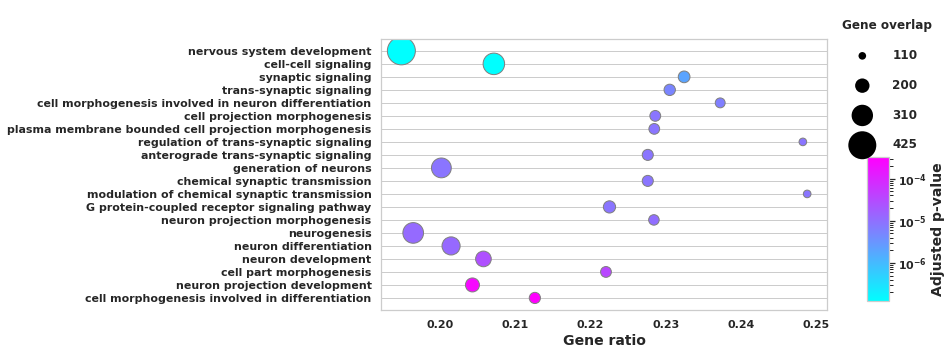

In [88]:
plot_enrich(astroC_enrichment)

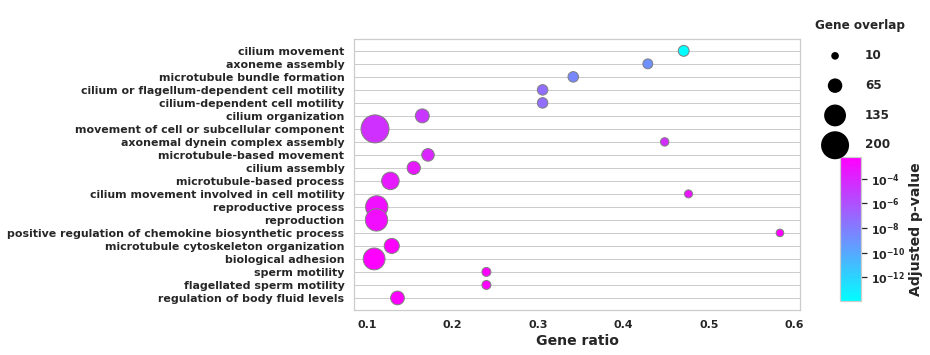

In [89]:
plot_enrich(astroSN_enrichment)

**Tasks:** 
1. Load the differential expression results where we also considered size factors in the test.
2. Run a gene set enrichment analysis with g:profiler. 
3. Save the resulting data frame as a `csv`.
4. Interpret the results: Which terms make sense, which don't? 
5. Adapt the input list of genes: Filter by increasing the log-fold change, reducing the q-value threshold or filter in addition by mean expression. Repeat the gene set enrichment analysis.

# Differences in donors in dopaminergic neurons

Read the result table for the dopaminergic neurons.

In [73]:
donor_DE = pd.read_csv(table_dir + 'test_MB_coef.csv', index_col=0)

In [74]:
donor_DE.head()

,gene,pval,qval,log2fc,mean,zero_mean,grad,coef_mle,coef_sd,ll
0,RP11-34P13.3,1.0,1.0,-1.454849e-14,0.000000,True,5.645568e-130,-1.454849e-14,6.642824e+64,-2.408032e-128
1,RP11-34P13.7,1.0,1.0,-1.454849e-14,0.000000,True,5.645568e-130,-1.454849e-14,6.642824e+64,-2.408032e-128
2,FO538757.2,0.0,0.0,2.839131e+02,0.506849,False,7.123278e-01,2.839131e+02,2.222759e-162,-3.898846e+02
3,AP006222.2,1.0,1.0,2.839131e+02,0.356164,False,5.479440e-01,2.839131e+02,3.705106e+09,-2.951754e+02
4,RP4-669L17.10,0.0,0.0,2.839131e+02,0.027397,False,5.480313e-02,2.839131e+02,2.222759e-162,-2.771955e+01


In [75]:
high_in_first = de_astro.loc[np.logical_and(donor_DE['log2fc']>0.5,
                                            donor_DE['qval']<0.05),
                                            'gene'].values
high_in_second = de_astro.loc[np.logical_and(donor_DE['log2fc']<-0.5,
                                             donor_DE['qval']<0.05),
                                              'gene'].values

In [76]:
print(len(high_in_first))
print(len(high_in_second))

12264
824


In this case, we specifically tested for changes concerning donor 5 compared to the rest. Let us review how these changes are reflected in gene sets.

## Run gprofiler

In [4]:
#Interpretation of differentially expressed genes in paneth cells - g:profiler
gp = GProfiler(return_dataframe=True, user_agent='g:GOSt')

In [77]:
DAN_donor5_enrichment = gp.profile(organism='hsapiens', sources=['GO:BP'], user_threshold=0.05,
                               significance_threshold_method='fdr', 
                               background=bg_genes, 
                               query=high_in_first.tolist())

In [78]:
DAN_rest_enrichment = gp.profile(organism='hsapiens', sources=['GO:BP'], user_threshold=0.05,
                               significance_threshold_method='fdr', 
                               background=bg_genes, 
                               query=high_in_second.tolist())

Let us check the results.

In [79]:
DAN_donor5_enrich_results = DAN_donor5_enrichment.set_index('native').sort_values('p_value').iloc[:,[2,5,7,10,1]]

In [82]:
pd.set_option("display.max_colwidth", 800)
DAN_donor5_enrich_results.iloc[:30,:]

,p_value,term_size,intersection_size,recall,name
native,,,,,
GO:0008150,4.580162e-47,14200,8501,0.598662,biological_process
GO:0009987,9.766796e-42,13013,7839,0.602398,cellular process
GO:0044237,3.823966e-37,9213,5696,0.618257,cellular metabolic process
GO:0006807,5.062886e-37,8550,5316,0.621754,nitrogen compound metabolic process
GO:0044238,1.215257e-36,8943,5538,0.619255,primary metabolic process
GO:0071704,4.263864e-36,9281,5727,0.617067,organic substance metabolic process
GO:0008152,7.552434e-33,9777,5989,0.612560,metabolic process
GO:0043170,1.359289e-32,7973,4957,0.621723,macromolecule metabolic process
GO:0034641,1.089661e-30,5488,3498,0.637391,cellular nitrogen compound metabolic process


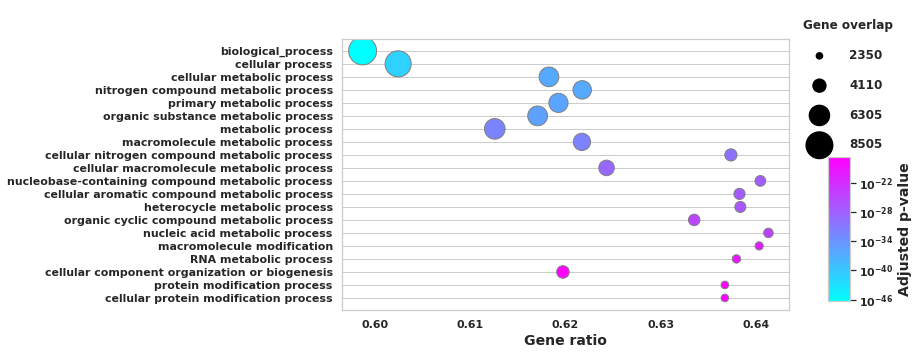

In [90]:
plot_enrich(DAN_donor5_enrichment)

Let us check the results.

In [83]:
DAN_rest_enrich_results = DAN_rest_enrichment.set_index('native').sort_values('p_value').iloc[:,[2,5,7,10,1]]

In [84]:
pd.set_option("display.max_colwidth", 800)
DAN_rest_enrich_results.iloc[:30,:]

,p_value,term_size,intersection_size,recall,name
native,,,,,
GO:0008150,8.242536e-09,14200,673,0.047394,biological_process
GO:0046907,7.374768e-06,1617,118,0.072975,intracellular transport
GO:0006412,3.550596e-05,610,57,0.093443,translation
GO:0009987,3.550596e-05,13013,615,0.047260,cellular process
GO:0043043,7.868478e-05,633,57,0.090047,peptide biosynthetic process
GO:0044237,8.510273e-05,9213,461,0.050038,cellular metabolic process
GO:0043604,1.439202e-04,767,64,0.083442,amide biosynthetic process
GO:0006518,1.439202e-04,753,63,0.083665,peptide metabolic process
GO:1901566,2.355752e-04,1654,112,0.067715,organonitrogen compound biosynthetic process


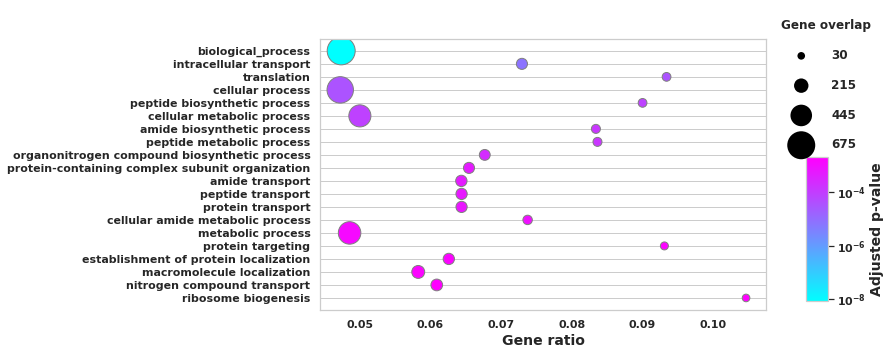

In [91]:
plot_enrich(DAN_rest_enrichment)

Both results show general GO terms, e.g. "cellular process", "metabolic process", or "gene expression". These results cannot be interpreted as donor-specific differences in dopaminergic neurons. Further, the list of differentially expressed genes specific for donor 5 included more than 10,000 genes (which are more than 50% of the expressed genes). Thus, our differential expression test might have picked up technical confounders such as library size differences since we did not correct with the size factor. 

This result indicates that the significance of a gene set is not per se informative if the underlying difference is actually meaningful. 

# List of all current user-defined variables

In [92]:
%whos

Variable                    Type         Data/Info
--------------------------------------------------
DAN_donor5_enrich_results   DataFrame                     p_value <...>n\n[289 rows x 5 columns]
DAN_donor5_enrichment       DataFrame        source      native   <...>\n[289 rows x 14 columns]
DAN_rest_enrich_results     DataFrame                     p_value <...>\n\n[61 rows x 5 columns]
DAN_rest_enrichment         DataFrame       source      native    <...>n\n[61 rows x 14 columns]
GProfiler                   type         <class 'gprofiler.gprofiler.GProfiler'>
adata                       AnnData      AnnData object with n_obs<...>'X_umap'\n    varm: 'PCs'
ann                         module       <module 'anndata' from '/<...>ges/anndata/__init__.py'>
astroC_enrich_results       DataFrame                     p_value <...>\n\n[99 rows x 5 columns]
astroC_enrichment           DataFrame       source      native    <...>n\n[99 rows x 14 columns]
astroSN_enrich_results      DataFrame    